In [10]:
import string
import numpy as np
from PIL import Image
import os
from pickle import dump, load
import numpy as np

from keras.applications.xception import Xception, preprocess_input
from tensorflow.keras.utils import load_img, img_to_array
from keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from tensorflow.keras.layers import add
from keras.models import Model, load_model
from keras.layers import Input, Dense, LSTM, Embedding, Dropout
from tqdm import tqdm_notebook as tqdm
tqdm().pandas()

<ipython-input-10-4752e610866b>:17: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  tqdm().pandas()


0it [00:00, ?it/s]

In [14]:
# Loading a text file
def load_document(filename):
    # Opening the file as read only
    file = open(filename, 'r')
    text = file.read()
    file.close()
    return text

In [15]:
# get all images with their captions
def image_captions(filename):
    file = load_document(filename)
    captions = file.split('\n')
    descriptions ={}
    for caption in captions[:-1]:
        image, caption = caption.split('\t')
        if image[:-2] not in descriptions:
            descriptions[image[:-2]] = [caption]
        else:
            descriptions[image[:-2]].append(caption)
    return descriptions

In [16]:
##Text data cleaning cleaning- lower casing, removing puntuations and words containing numbers
def cleaning_text(captions):
    table = str.maketrans('','',string.punctuation)
    for image,caps in captions.items():
        for i,image_caption in enumerate(caps):

            image_caption.replace("-"," ")
            description = image_caption.split()

            #converts to lower case
            description = [word.lower() for word in description]
            #remove punctuation from each token
            description = [word.translate(table) for word in description]
            #remove hanging 's and a 
            description = [word for word in description if(len(word)>1)]
            #remove tokens with numbers in them
            description = [word for word in description if(word.isalpha())]
            #convert back to string

            image_caption = ' '.join(description)
            captions[image][i]= image_caption
    return captions

In [17]:
def text_vocabulary(descriptions):
    # build vocabulary of all unique words
    vocab = set()
    
    for key in descriptions.keys():
        [vocab.update(d.split()) for d in descriptions[key]]
    
    return vocab

In [18]:
#adding and saving all descriptions in one file 
def save_descriptions(descriptions, filename):
    lines = list()
    for key, description_list in descriptions.items():
        for description in description_list:
            lines.append(key + '\t' + description )
    data = "\n".join(lines)
    file = open(filename,"w")
    file.write(data)
    file.close()

In [19]:
dataset_text = "drive/MyDrive/Project/Flickr8k_text"
dataset_images = "drive/MyDrive/Project/Flicker8k_Dataset"

In [20]:
#we prepare our text data
filename = dataset_text + "/" + "Flickr8k.token.txt"
#loading the file that contains all data
#mapping them into descriptions dictionary image to 5 captions
descriptions = image_captions(filename)
print("Length of descriptions =" ,len(descriptions))

#cleaning the descriptions
clean_descriptions = cleaning_text(descriptions)

#building vocabulary 
vocabulary = text_vocabulary(clean_descriptions)
print("Length of vocabulary = ", len(vocabulary))

#saving each description to file 
save_descriptions(clean_descriptions, "descriptions.txt")

Length of descriptions = 8092
Length of vocabulary =  8763


In [21]:
def extract_features(directory):
        model = Xception( include_top=False, pooling='avg' )
        features = {}
        for image in tqdm(os.listdir(directory)):
            filename = directory + "/" + image
            image = Image.open(filename)
            image = image.resize((299,299))
            image = np.expand_dims(image, axis=0)
            image = image/127.5
            image = image - 1.0
            
            feature = model.predict(image)
            features[image] = feature
        return features

In [25]:
features = load(open("features.p","rb"))

In [26]:
#load the photos
def load_photos(filename):
    file = load_document(filename)
    photos = file.split("\n")[:-1]
    return photos

#loading cleaned descriptions
def load_cleaned_descriptions(filename, photos):   

    file = load_document(filename)
    descriptions = {}
    for line in file.split("\n"):
        
        words = line.split()
        if len(words)<1 :
            continue
    
        image, image_caption = words[0], words[1:]
        
        if image in photos:
            if image not in descriptions:
                descriptions[image] = []
            desc = '<start> ' + " ".join(image_caption) + ' <end>'
            descriptions[image].append(desc)

    return descriptions

#loading all features
def load_features(photos):
    all_features = load(open("features.p","rb"))
    #selecting only needed features
    features = {k:all_features[k] for k in photos}
    return features


In [27]:
filename = dataset_text + "/" + "Flickr_8k.trainImages.txt"
train_images = load_photos(filename)
train_descriptions = load_cleaned_descriptions("descriptions.txt", train_images)
train_features = load_features(train_images)

In [28]:
#converting dictionary to clean list of descriptions
def dict_to_list(descriptions):
    all_desc = []
    for key in descriptions.keys():
        [all_desc.append(d) for d in descriptions[key]]
    return all_desc

#creating tokenizer class 
#this will vectorise text corpus
#each integer will represent token in dictionary 

from keras.preprocessing.text import Tokenizer

def create_tokenizer(descriptions):
    desc_list = dict_to_list(descriptions)
    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(desc_list)
    return tokenizer


In [29]:
# give each word a index, and store that into tokenizer.p pickle file
tokenizer = create_tokenizer(train_descriptions)
dump(tokenizer, open('tokenizer.p', 'wb'))
vocab_size = len(tokenizer.word_index) + 1
vocab_size 

7577

In [30]:
#calculate maximum length of descriptions
def max_length(descriptions):
    description_list = dict_to_list(descriptions)
    return max(len(d.split()) for d in description_list)

max_length = max_length(descriptions)
max_length

32

In [31]:
features['1000268201_693b08cb0e.jpg'][0]

array([0.36452794, 0.12713662, 0.0013574 , ..., 0.221817  , 0.01178991,
       0.24176797], dtype=float32)

In [32]:
#create input-output sequence pairs from the image description.

#data generator, used by model.fit_generator()
def data_generator(descriptions, features, tokenizer, max_length):
    while 1:
        for key, description_list in descriptions.items():
            #retrieve photo features
            feature = features[key][0]
            input_image, input_sequence, output_word = create_sequences(tokenizer, max_length, description_list, feature)
            yield [[input_image, input_sequence], output_word]         

def create_sequences(tokenizer, max_length, description_list, feature):
    X1, X2, y = list(), list(), list()
    # walk through each description for the image
    for description in description_list:
        # encode the sequence
        seq = tokenizer.texts_to_sequences([description])[0]
        # split one sequence into multiple X,y pairs
        for i in range(1, len(seq)):
            # split into input and output pair
            input_seq, output_seq = seq[:i], seq[i]
            # pad input sequence
            input_seq = pad_sequences([input_seq], maxlen=max_length)[0]
            # encode output sequence
            output_seq = to_categorical([output_seq], num_classes=vocab_size)[0]
            # store
            X1.append(feature)
            X2.append(input_seq)
            y.append(output_seq)
    return np.array(X1), np.array(X2), np.array(y)

In [33]:
[a,b],c = next(data_generator(train_descriptions, features, tokenizer, max_length))
a.shape, b.shape, c.shape

((47, 2048), (47, 32), (47, 7577))

In [ ]:
from keras.utils import plot_model

# define the captioning model
def define_model(vocab_size, max_length):
    
    # features from the CNN model squeezed from 2048 to 256 nodes
    inputs1 = Input(shape=(2048,))
    feature1 = Dropout(0.5)(inputs1)
    feature2 = Dense(256, activation='relu')(feature1)

    # LSTM sequence model
    inputs2 = Input(shape=(max_length,))
    sequence1 = Embedding(vocab_size, 256, mask_zero=True)(inputs2)
    sequence2 = Dropout(0.5)(sequence1)
    sequence3 = LSTM(256)(sequence2)

    # Merging both models
    decoder1 = add([feature2, sequence3])
    decoder2 = Dense(256, activation='relu')(decoder1)
    outputs = Dense(vocab_size, activation='softmax')(decoder2)
    
    # tie it together [image, seq] [word]
    model = Model(inputs=[inputs1, inputs2], outputs=outputs)
    model.compile(loss='categorical_crossentropy', optimizer='adam')
    
    # summarize model
    print(model.summary())
    plot_model(model, to_file='model.png', show_shapes=True)
    
    return model

In [ ]:
# train our model
print('Dataset: ', len(train_images))
print('Descriptions: train=', len(train_descriptions))
print('Photos: train=', len(train_features))
print('Vocabulary Size:', vocab_size)
print('Description Length: ', max_length)

model = define_model(vocab_size, max_length)
epochs = 10
steps = len(train_descriptions)
# making a directory models to save our models
os.mkdir("models")
#training model and saving it on each epoch
for i in range(epochs):
    generator = data_generator(train_descriptions, train_features, tokenizer, max_length)
    model.fit_generator(generator, epochs=1, steps_per_epoch= steps, verbose=1)
    model.save("models/model_" + str(i) + ".h5")

Dataset:  6000
Descriptions: train= 6000
Photos: train= 6000
Vocabulary Size: 7577
Description Length:  32
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 32)]         0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None, 2048)]       0           []                               
                                                                                                  
 embedding (Embedding)          (None, 32, 256)      1939712     ['input_3[0][0]']                
                                                                                                  
 dropout (Dropout)              (None, 2048)         0           ['input_2[0][0]']    

<ipython-input-35-7600b5951421>:15: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  model.fit_generator(generator, epochs=1, steps_per_epoch= steps, verbose=1)


6000/6000 [==============================] - 1618s 270ms/step - loss: 2.7987


In [41]:
#library files
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import argparse
image_path = "image.jpg"

In [35]:
#extracing image from the folder and extracting its features
def extract_features(filename, model):
        try:
            image = Image.open(filename)
        except:
            print("ERROR: Couldn't open image! Make sure the image path and extension is correct")
        image = image.resize((299,299))
        image = np.array(image)
        # for images that has 4 channels, we convert them into 3 channels
        if image.shape[2] == 4: 
            image = image[..., :3]
        image = np.expand_dims(image, axis=0)
        image = image/127.5
        image = image - 1.0
        feature = model.predict(image)
        return feature

In [36]:
def word_for_id(integer, tokenizer):
  for word, index in tokenizer.word_index.items():
     if index == integer:
         return word
  return None

In [37]:
#function defined to describe the image selected
def generate_description(model, tokenizer, photo, max_length):
    in_text = 'start'
    for i in range(max_length):
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        sequence = pad_sequences([sequence], maxlen=max_length)
        pred = model.predict([photo,sequence], verbose=0)
        pred = np.argmax(pred)
        word = word_for_id(pred, tokenizer)
        if word is None:
            break
        in_text += ' ' + word
        if word == 'end':
            break
    return in_text

1/1 [==============================] - 1s 1s/step



start boy swims underwater end


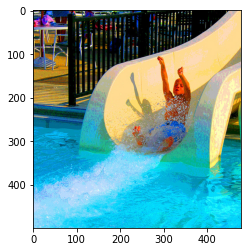

In [42]:
max_length = 32
tokenizer = load(open("tokenizer.p","rb"))
model = load_model('model_9.h5')
xception_model = Xception(include_top=False, pooling="avg")
photo = extract_features(image_path, xception_model)
image= Image.open(image_path)
description = generate_description(model, tokenizer, photo, max_length)
print("\n\n")
print(description)
plt.imshow(image)